<a href="https://colab.research.google.com/github/danielbauer1979/CAS_PredMod/blob/main/pa_pynb_sess8_NeuralNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 9 - Artificial Neural Nets
Daniel Bauer, 2022

In this tutorial, we will get to know artificial neural networks for the purpose of prediction.  Neural nets present a powerful statistical learning technique, but there are also various pitfalls.  In the first part of this tutorial, we will demonstrate both their power and key issues.  More precisely, we will look at two separate regression examples where their performance comes out different. This will help us understand some of the accolades and downsides.  We will then evaluate the performance of neural nets in the context of our credit card case study.

As usually, we start by importing the relevant libararies:

In [77]:
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd 

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, roc_curve, auc
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

And for later use, we defined the sigmoid function:

In [ ]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

## Artificial Neural Networks

### Review of Concepts and Maths

As we discussed in lecture, a neural net generally consists of an *input layer* with the features $X_1,\ldots,X_p,$ one or more *hidden layers* with *neurons* $Z_1,\ldots,Z_M,$ and an *output layer*.  In the case of a one-dimensional regression problem, the output layer consists of a single outcome $Y.$  

In a single-layer neural network, the inputs are processed into the neurons of the hidden layer, which in turn are processed into the outputs.  More precisely, for each neuron $Z_m$, the $X_j$'s are linearly aggregated and transformed via a sigmoid function:   
$$
\boxed{\begin{array}{rcl}
Z_m &=& \sigma(\alpha_{0m} + 
\alpha_{m,1}\,X_1 + \alpha_{m,2}\,X_2 + \ldots + \alpha_{m,p}\,X_p)\\
Y &=& \beta_0 + \beta_1\,Z_1 + \beta_2\,Z_2 + \ldots + \beta_M\,Z_M + \varepsilon
\end{array}}
$$
The sigmoid function has the appealing property that it can depict highly linear and highly non-linear relationships.  The constant term ($\alpha_{0m}$) together with the norm of the coefficient vector $(\alpha_{m1},\ldots,\alpha_{mp})$ determines how (non-)linear the relationship in that neuron is.  The neurons are then aggregated to the response $Y.$  In a *deep* neural network, there are several hidden layers in which the neurons are processed into other neurons.

As a consequence, the number of parameters in a neural network quickly becomes large:  For instance, in a single-layer network with a one-dimensional response, we have *weights* for each neuron ($\{\alpha_{0m},\alpha_{m},m=1,\ldots,M\}$), amounting to $M \times (p+1)$ parameters, and then another $M+1$ parameters in producing $Y$ ($\{\beta_0,\beta\}$).  The number increases drastically for more hidden layers.

### Simulated Example I: Complex Relationship, No Noise, Lots of Data

We start with a rather complex relationship between inputs and outputs but assume there is no random noise ($\varepsilon$ is zero) and that we are in a data-rich environment:


In [2]:
np.random.seed(1)
x1 = np.random.normal(0, 1, 20000)
x2 = np.random.normal(0, 1, 20000)
y = (x1+0.5)*(x1+0.5)*(x1+0.5)*(x2-0.3)*(x2-0.3)+50*1/(1+np.exp(3*x1+2*x2))

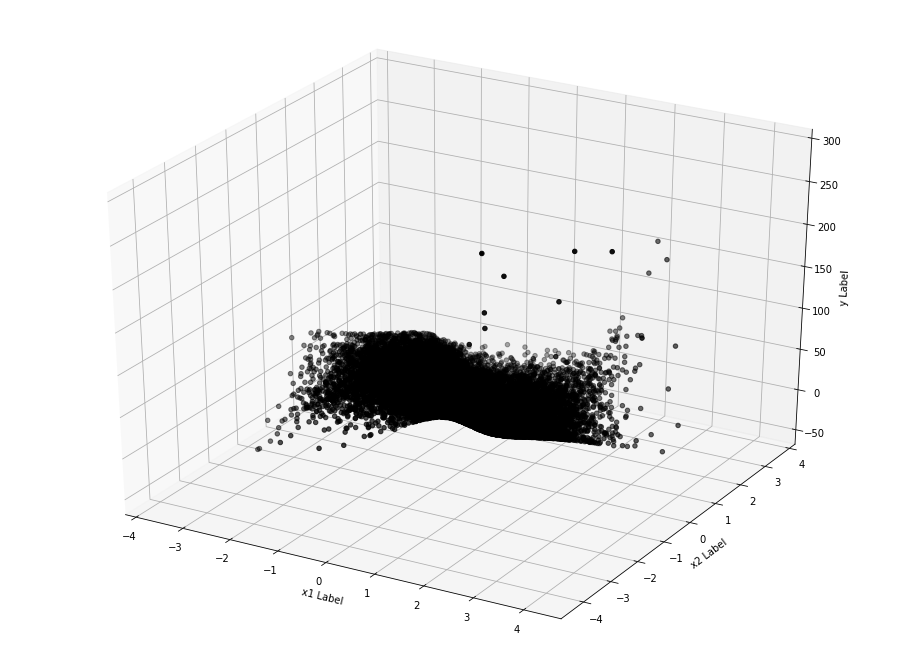

In [3]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y, c='k', marker='o')

ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

So we observe that the relationship is relatively complex in both variables.  


Let's zoom in a bit:

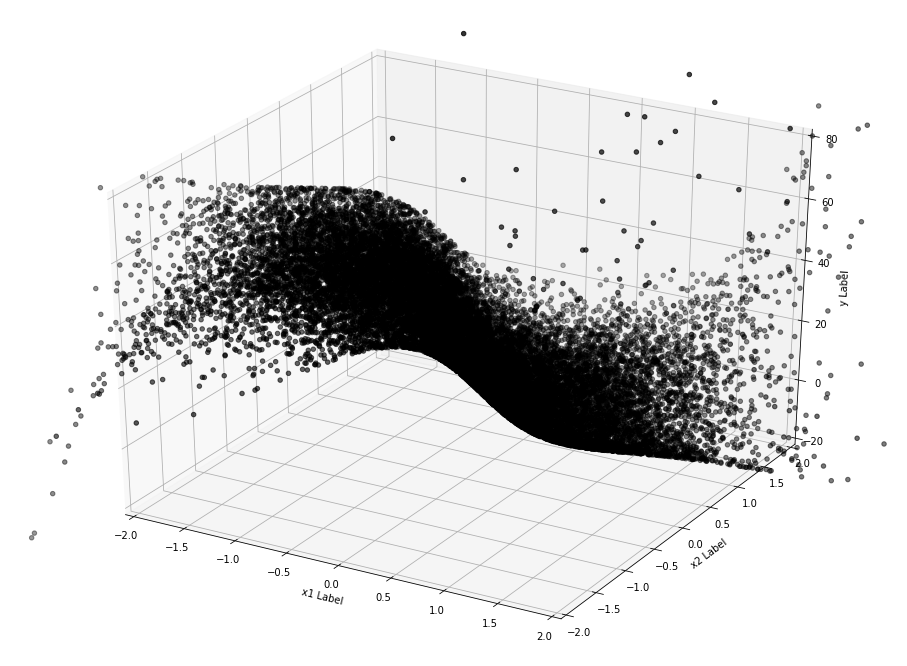

In [4]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,80)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

Let's see if a neural network can fit the relationship.

There are multiple choices for neuralnetwork packages in Python. The one from scikit has similar setting the one in R. Here we rely on keras in tensorflow, which is a package that can do heavy lifting. 

We start by putting together the dataframe...

In [5]:
mydata1 = pd.DataFrame({'y':y,'x1':x1,'x2':x2})

...and scale the data:

In [6]:
mydata1_sc = scale(mydata1)

In [8]:
X_train = mydata1_sc[:,1:3]
y_train = mydata1_sc[:,0]

Let's run a simple network with two layers and three neurons in the first layer and 3 neurons in the second layer:

In [17]:
inputs = keras.Input(shape=(2,)) # we have a two-dimensional input layer
x = layers.Dense(5, activation="sigmoid", name="dense_1")(inputs) #the next layer takes the inputs and pushes them into 5 neurons; we use signoid activation
z = layers.Dense(3, activation="sigmoid", name="dense_2")(x) #the next layer takes the 5 neurons as input and pushes them into 3 neurons; again we use sigmoid activation
outputs = layers.Dense(1, activation="linear", name="predictions")(x) #the output is single dimension

model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimize 
    loss=keras.losses.MeanSquaredError(),  # Loss function to minimize
    metrics=[keras.metrics.MeanSquaredError()], # List of metrics to monitor
)

In [20]:
history = model.fit(
    X_train,
    y_train,
    # batch_size=64,
    epochs=25
)

Epoch 1/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0792 - mean_squared_error: 0.0792
Epoch 2/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0726 - mean_squared_error: 0.0726
Epoch 3/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0680 - mean_squared_error: 0.0680
Epoch 4/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 5/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0629 - mean_squared_error: 0.0629
Epoch 6/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0611 - mean_squared_error: 0.0611
Epoch 7/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0585 - mean_squared_error: 0.0585
Epoch 8/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 9/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 10/2

Let's look at the predictions:

In [21]:
pred_sc = model.predict(X_train)
preds_1 = pred_sc*np.std(mydata1).y + np.mean(mydata1).y #WE rescale up
compare = pd.DataFrame({'y':y,'preds_1':preds_1.T[0]})
compare.head()

,y,preds_1
0,61.091165,57.218147
1,44.811675,44.268982
2,48.131747,47.119030
3,48.661676,47.573921
4,1.816804,1.813911


In [22]:
mean_squared_error(mydata1.y, preds_1.T[0])

10.873027501318152

So we get pretty close:

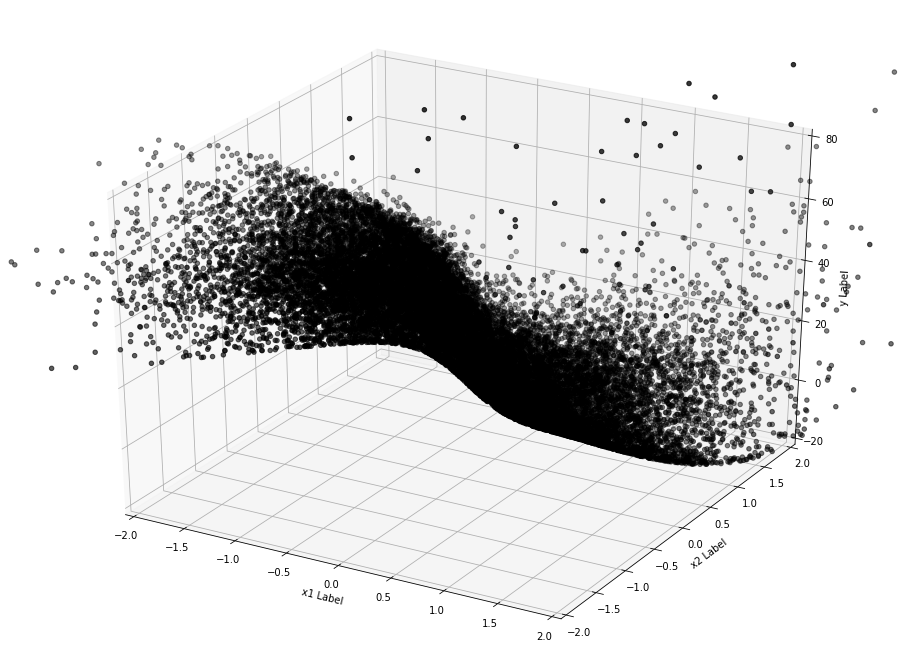

In [23]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, preds_1.T[0], c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,80)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

As we can see, based on the first few predictions, the network seems to work quite well. The plot demonstrates that the neural net fit is able to depict the relationship quite adequately.   

### Simulated Example II: Simple Relationship, Lots of Noise, Little Data

Let's continue with a second example, where the relationship is a lot simpler, the dataset is smaller, and where there is significant noise -- so that the *signal-to-noise ratio* is relatively low.

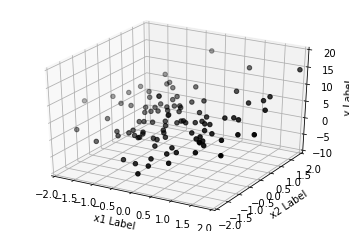

In [24]:
np.random.seed(3)
x1 = np.random.normal(0, 1, 100)
x2 = np.random.normal(0, 1, 100)
x3 = np.random.normal(0, 1, 100)
y2_true = 3 + 2 * x1 + 4 * x2 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2_true, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-10,20)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

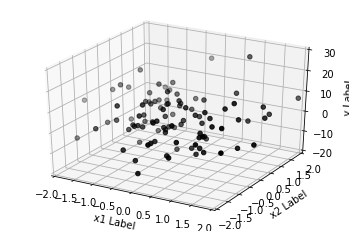

In [26]:
y2 = y2_true + 5 * np.random.normal(0, 1, 100)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,30)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

In [27]:
mydata2 = pd.DataFrame({'y2':y2,'x1':x1,'x2':x2,'x3':x3})
mydata2_sc = scale(mydata2)

Let's again run a two-layer neural network:

In [28]:
X_train = mydata2_sc[:,1:4]
y_train = mydata2_sc[:,0]

inputs = keras.Input(shape=(3,))
x = layers.Dense(5, activation="sigmoid", name="dense_1")(inputs)
z = layers.Dense(3, activation="sigmoid", name="dense_2")(x)
outputs = layers.Dense(1, activation="linear", name="predictions")(z)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)

history = model.fit(
    X_train,
    y_train,
    # batch_size=64,
    epochs=15
)

Epoch 1/15
4/4 [==============================] - 0s 3ms/step - loss: 1.1319 - mean_squared_error: 1.1319
Epoch 2/15
4/4 [==============================] - 0s 4ms/step - loss: 1.0507 - mean_squared_error: 1.0507
Epoch 3/15
4/4 [==============================] - 0s 3ms/step - loss: 1.0191 - mean_squared_error: 1.0191
Epoch 4/15
4/4 [==============================] - 0s 4ms/step - loss: 0.9990 - mean_squared_error: 0.9990
Epoch 5/15
4/4 [==============================] - 0s 3ms/step - loss: 0.9942 - mean_squared_error: 0.9942
Epoch 6/15
4/4 [==============================] - 0s 2ms/step - loss: 0.9892 - mean_squared_error: 0.9892
Epoch 7/15
4/4 [==============================] - 0s 3ms/step - loss: 0.9831 - mean_squared_error: 0.9831
Epoch 8/15
4/4 [==============================] - 0s 2ms/step - loss: 0.9764 - mean_squared_error: 0.9764
Epoch 9/15
4/4 [==============================] - 0s 2ms/step - loss: 0.9725 - mean_squared_error: 0.9725
Epoch 10/15
4/4 [=============================

And let's generate predictions:

In [30]:
pred2_sc = model.predict(X_train)
preds_2 = pred2_sc*np.std(mydata2).y2 + np.mean(mydata2).y2

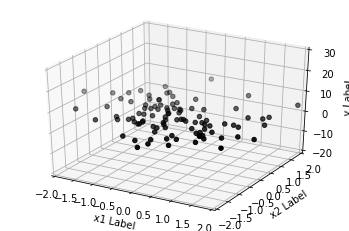

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, preds_2, c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,30)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

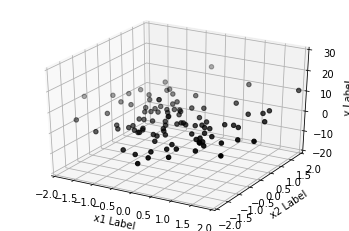

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2_true-preds_2.T[0], c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,30)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

In [33]:
mean_squared_error(y2_true, preds_2.T[0])

9.98332169295718

Let's compare to a simple linear regression model:

In [34]:
lmfit = smf.ols(formula="y2 ~ x1 + x2 + x3", data=mydata2).fit()
yhat_OOS = lmfit.predict(mydata2.drop(columns = ["y2"]))
print(lmfit.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     14.33
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           8.68e-08
Time:                        02:04:27   Log-Likelihood:                -308.23
No. Observations:                 100   AIC:                             624.5
Df Residuals:                      96   BIC:                             634.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2953      0.561      4.089      0.0

In [35]:
mean_squared_error(y2_true, yhat_OOS)

1.4136322850403868

As we can see, even though the relationship between the inputs and the (non-noisy) outputs is relatively simple, the neural network predicts a more complex one.  The residuals (relative to the non-noisy outcomes) are quite sizable relative to the data and the predictions.  Clearly, the neural network is overfitting the data.

For the OLS regression, the prediction error is low.  Of course, this may not be suprising given that the original relationship corresponds to a linear model -- but that's the point.  A simpler model will outperform the more advanced model if it is able to accurately depict the relationship!

Let's increase the learning rate and reduce the number of epochs to have less potential for ovefitting.  Let's check:

In [53]:
inputs = keras.Input(shape=(3,))
x = layers.Dense(5, activation="sigmoid", name="dense_1")(inputs)
x = layers.Dense(3, activation="sigmoid", name="dense_2")(x)
outputs = layers.Dense(1, activation="linear", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)

history = model.fit(
    X_train,
    y_train,
    # batch_size=64,
    epochs=10
)

Epoch 1/10
4/4 [==============================] - 0s 3ms/step - loss: 1.1538 - mean_squared_error: 1.1538
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 1.0541 - mean_squared_error: 1.0541
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.9681 - mean_squared_error: 0.9681
Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.9184 - mean_squared_error: 0.9184
Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.8802 - mean_squared_error: 0.8802
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8333 - mean_squared_error: 0.8333
Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.8262 - mean_squared_error: 0.8262
Epoch 8/10
4/4 [==============================] - 0s 2ms/step - loss: 0.7992 - mean_squared_error: 0.7992
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7640 - mean_squared_error: 0.7640
Epoch 10/10
4/4 [=============================

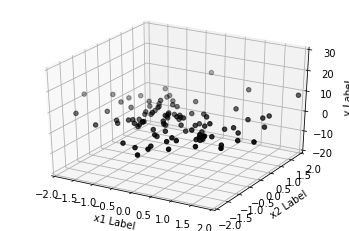

In [54]:
pred2_3_sc = model.predict(X_train)
preds_2_3 = pred2_3_sc*np.std(mydata2).y2 + np.mean(mydata2).y2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y2_true-preds_2_3.T[0], c='k', marker='o')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-20,30)
ax.set_xlabel('x1 Label')
ax.set_ylabel('x2 Label')
ax.set_zlabel('y Label')

plt.show()

In [55]:
mean_squared_error(y2_true, preds_2_3.T[0])

4.731988914338492

So the performance improves but is not on par with the more suitable model.

## Case Study: Credit Card Defaults

Let's go back to our example, where again we only consider a few of the factor `PAY` variables given our previous experiences, and limitations of these methods with categorical variables.

Let's load the (prepped) data:

In [56]:
!git clone https://github.com/danielbauer1979/CAS_PredMod.git

Cloning into 'CAS_PredMod'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 102 (delta 10), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (102/102), 19.52 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [63]:
mydata = pd.read_csv('CAS_PredMod/pa_data_UCI_Credit_Card_prepped.csv', index_col=0)

In [64]:
mydata.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_REC,BILL_AVG,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,1284.000000,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,2846.166667,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,16942.166667,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,38555.666667,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,18223.166667,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Let's scale the numerical variables

In [66]:
factor = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4','PAY_5', 'PAY_6', 'default']
mydata_numcols = mydata.drop(columns = factor)
mydata_faccols = mydata[factor].drop(columns = ['default']).astype('category')
dummies = pd.get_dummies(mydata_faccols, drop_first=True)
mydata_numcols_sc_0 = scale(mydata_numcols)
mydata_numcols_sc = pd.DataFrame(data=mydata_numcols_sc_0, columns = mydata_numcols.columns, index = dummies.index)
mydata_sc = pd.concat([mydata_numcols_sc, dummies], axis = 1)
mydata_sc = pd.concat([mydata_sc, mydata['default']], axis = 1)
mydata_sc.head()

,LIMIT_BAL,AGE,BILL_REC,BILL_AVG,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,...,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,default
ID,,,,,,,,,,,,,,,,,,,,,
1,-1.136720,-1.246020,-0.642501,-0.690692,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,...,0,0,0,0,0,0,0,0,0,1
2,-0.365981,-1.029047,-0.659219,-0.665997,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,...,1,0,0,0,0,0,1,0,0,1
3,-0.597202,-0.161156,-0.298560,-0.443170,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,...,1,0,0,0,0,1,0,0,0,0
4,-0.905498,0.164303,-0.057491,-0.101507,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,...,1,0,0,0,0,1,0,0,0,0
5,-0.905498,2.334029,-0.578618,-0.422920,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,...,1,0,0,0,0,1,0,0,0,0


Let's split the data and fit the model:

In [68]:
train, test = train_test_split(mydata_sc, test_size=0.25)
X_train = train.drop(columns = ['default']).values
y_train = train['default'].values
X_test = test.drop(columns = ['default']).values
y_test = test['default'].values

In [71]:
inputs = keras.Input(shape=(54,))
x = layers.Dense(6, activation="relu", name="dense_1")(inputs)
x = layers.Dense(5, activation="relu", name="dense_2")(x)
x = layers.Dense(4, activation="sigmoid", name="dense_3")(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)
credit_nnet = keras.Model(inputs=inputs, outputs=outputs)
credit_nnet.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  # Loss function to minimize
  loss='binary_crossentropy',
  # List of metrics to monitor
  metrics=['accuracy'],
)

In [73]:
history = credit_nnet.fit(
  X_train,
  y_train,
  batch_size=45,
  epochs=50
)

Epoch 1/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4276 - accuracy: 0.8226
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4274 - accuracy: 0.8220
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4271 - accuracy: 0.8223
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4269 - accuracy: 0.8219
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4268 - accuracy: 0.8228
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4269 - accuracy: 0.8224
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4267 - accuracy: 0.8228
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4266 - accuracy: 0.8220
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4265 - accuracy: 0.8224
Epoch 10/50
500/500 [==============================] - 1s 2ms/step - loss: 0.4264 - accuracy: 0.8221

In [78]:
mypreds = credit_nnet.predict(X_test)
mypreds_bin = mypreds > 0.5
table = pd.DataFrame({'True':y_test,'pred':mypreds_bin.T[0]})
table.groupby(['True','pred']).size().unstack('True')

True,0,1
pred,,
False,5659,1073
True,241,527


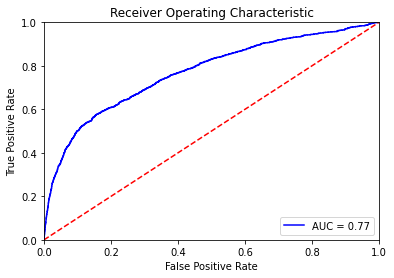

In [79]:
fpr, tpr, threshold = roc_curve(y_test, mypreds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()